In [1]:
import pandas as pd
from ml_model import PipelineManager
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
import numpy as np
from sklearn import set_config
from sklearn. preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
set_config(display="diagram")

In [3]:
df_notas = pd.read_csv('../data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('../data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('../data/sociodemografico.csv', sep=';')

In [4]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [5]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [7]:
df_notas = df_notas.dropna()
df_notas['IDRecord'] = df_notas['IDRecord'].astype(str)
df_notas = df_notas[df_notas.IDRecord.str.isnumeric()]
df_notas['IDRecord'] = df_notas['IDRecord'].astype(int)

In [8]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINÚA EN PROGRAMA DE CRÓNICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...


In [9]:
numerical_features = ['Edad']
categorical_features=['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo']
text_features='Plan'

target_feature = 'Código'

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_features(text_features)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    "bootstrap": [True, False],
}
estimator = RandomForestClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta":  np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 100, dtype=float),
    "reg_alpha": np.linspace(0, 10, 100, dtype=float),
    "scale_pos_weight": np.linspace(0.1, 1.5, 5, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

pipeline.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Edad']),
                                                 ('text',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(strip_accents='unicode')),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  'Plan')])),
                ('feature_selector',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('estimator', RandomForestClassifier())])

In [10]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42)

In [11]:
best_model = pipeline.find_best_model(X_train, y_train, cv=2, n_iter=16, n_jobs=-2, scoring='roc_auc')
pipeline.cv_results

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[19:28:06] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__numerical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__scale_pos_weight,param_estimator__reg_lambda,param_estimator__reg_alpha,...,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1268.658089,18.541448,0.009308,0.005144,KNNImputer(),SelectFromModel(estimator=RandomForestRegresso...,0.1,1.15,8.686869,9.69697,...,0.5,0.391111,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': KNNImpute...,NaN,NaN,NaN,NaN,1
1,8.415572,0.446413,0.001938,0.000055,KNNImputer(),SelectFromModel(estimator=ElasticNet()),0.1,0.45,7.171717,3.030303,...,1.0,0.336667,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': KNNImpute...,NaN,NaN,NaN,NaN,2
2,7.695871,0.078580,0.002099,0.000253,SimpleImputer(strategy='median'),SelectFromModel(estimator=ElasticNet()),0.55,0.8,9.393939,3.939394,...,0.25,0.064444,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': SimpleImp...,NaN,NaN,NaN,NaN,3
3,1328.183071,33.032233,0.003484,0.002248,KNNImputer(),SelectFromModel(estimator=RandomForestRegresso...,0.1,0.1,3.333333,2.424242,...,0.0,0.064444,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': KNNImpute...,NaN,NaN,NaN,NaN,4
4,7.504682,0.511229,0.001250,0.000527,SimpleImputer(),SelectFromModel(estimator=ElasticNet()),0.1,0.8,8.686869,4.242424,...,1.0,0.391111,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': SimpleImp...,NaN,NaN,NaN,NaN,5
5,1283.624952,33.177642,0.001049,0.000000,KNNImputer(),SelectFromModel(estimator=RandomForestRegresso...,0.1,1.5,8.080808,2.727273,...,0.5,0.227778,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': KNNImpute...,NaN,NaN,NaN,NaN,6
6,1585.571980,225.688554,0.001295,0.000516,SimpleImputer(strategy='median'),SelectFromModel(estimator=RandomForestRegresso...,0.55,1.15,9.69697,0.606061,...,0.25,0.282222,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': SimpleImp...,NaN,NaN,NaN,NaN,7
7,1860.147353,7.305170,0.003657,0.000761,SimpleImputer(strategy='median'),SelectFromModel(estimator=RandomForestRegresso...,0.775,1.15,2.222222,6.767677,...,1.0,0.227778,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': SimpleImp...,NaN,NaN,NaN,NaN,8
8,1715.265312,29.400670,0.000804,0.000090,SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=RandomForestRegresso...,0.1,0.45,3.131313,9.494949,...,1.0,0.336667,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': SimpleImp...,NaN,NaN,NaN,NaN,9
9,10.185554,0.215006,0.000829,0.000005,SimpleImputer(strategy='median'),SelectFromModel(estimator=ElasticNet()),0.775,0.45,3.535354,8.282828,...,0.0,0.227778,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__numerical__imputer': SimpleImp...,NaN,NaN,NaN,NaN,10


In [12]:
score = pipeline.score(X_test, y_test)
score

,ROC_AUC,accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized
0,0.711047,0.601461,0.601461,0.222167,0.567066,"[[0, 0, 0, 0, 646, 125, 0, 9, 0], [0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.005763123148842022, 0...."


In [13]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)
labels_decoded

array(['A510', 'A511', 'A514', 'A529', 'A530', 'A539', 'E109', 'E119',
       'E149'], dtype=object)

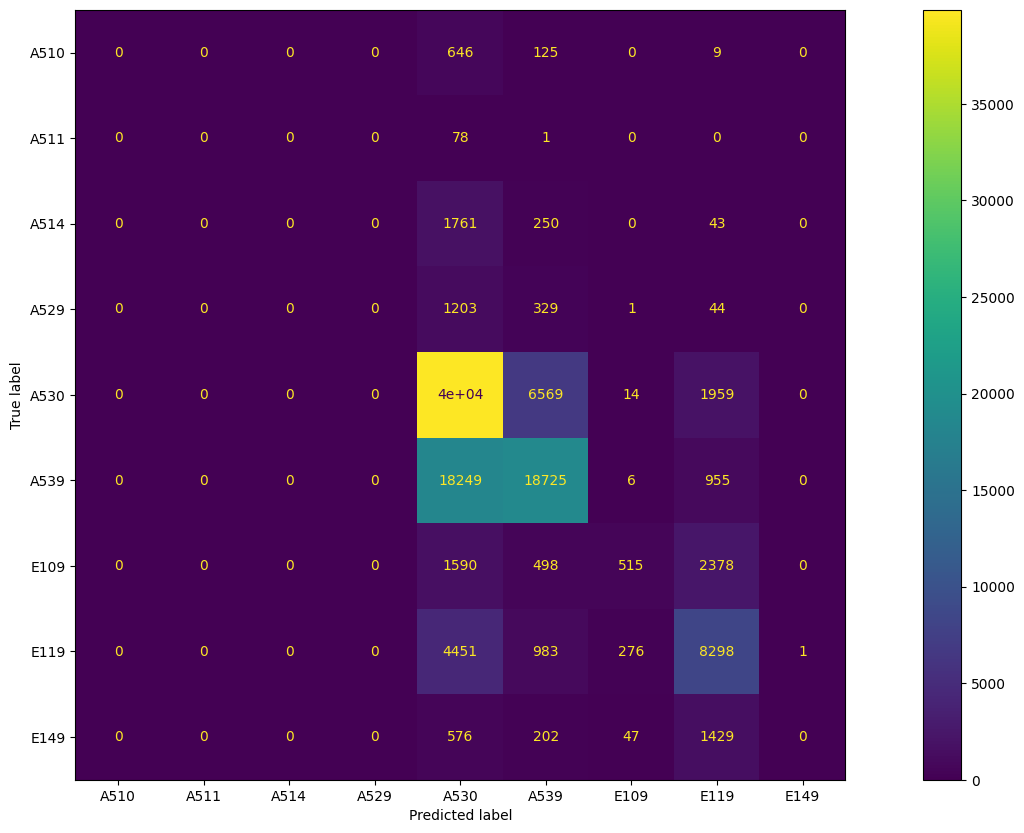

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                             display_labels=labels_decoded)
disp.plot(ax=ax)
plt.show()